In [2]:
import sys
sys.path.append('..')

import attack
import data_loader as dl

In [3]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point
import math
from sklearn import metrics
from tqdm import tqdm
import os
import datetime
tqdm.pandas()

import sys
# sys.stdout = open('logfile', 'w')

In [17]:
# Load data
gdf = gp.read_file('data/freemove/freemove_clustering_HL_private_500tessellation.geojson').to_crs(4326)

# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

gdf = gdf.reset_index(drop=True)

In [18]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    500  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "squared"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
)#.drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [19]:
def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

print(len(tessellation))
print('nr unique', tessellation.tile_ID.nunique())

tessellation.explore()

In [20]:
def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le

In [21]:
def get_inverse_loc_frequency(row, loc_frequencies, points):
    
    tl_ID = str(row.tile_ID)
    cl_ID = row.clustering_HL
    
    cl_loc_freqs = loc_frequencies.query('clustering_HL == @cl_ID')
        
    tf = row.freq/cl_loc_freqs.freq.sum()
    
    idf = math.log(points.clustering_HL.nunique()/(points.query('tile_ID == @tl_ID').clustering_HL.nunique() + 1))
    
    tf_idf = tf * idf
    
    return tf_idf

In [22]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    nr_overlapping_tiles = len(overlap_tile_ids)
    loc_sim = 0
    
    if nr_overlapping_tiles == 0:
        return loc_sim
    for t in overlap_tile_ids:
        cl_i_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        cl_j_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        
        # Alternative 1: Entropy times avg lficf
#         loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * (cl_i_freq + cl_j_freq)/2

        # Alternative 2: Interaction between lficfs
        loc_sim += cl_i_freq + cl_j_freq
    return loc_sim/nr_overlapping_tiles

In [23]:
def get_max_n(M, n=10):
    # (score, i, j)
    max_n = [(0,0,0)] * n
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not all(x[0] > M[i,j] for x in max_n):
                index_smallest_val = max_n.index(sorted(max_n, reverse=False)[0])
                max_n[index_smallest_val] = (M[i,j], i, j) # score must be first for sorting later
    
    print('Nr of links that are equal to one of max values: ', sum([sum(M == max_val[0]).sum() for max_val in max_n]))
    return max_n

In [24]:
def find_nr_overlaps(cl_i, cl_j, gdf):
    nr_overlaps = 0
    
    gdf['TRIP_START'] = pd.to_datetime(gdf['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
    gdf['TRIP_END'] = pd.to_datetime(gdf['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    
    cl_i_trips = gdf.query("clustering_HL == @cl_i").copy()
    cl_j_trips = gdf.query("clustering_HL == @cl_j").copy()
    
    for i, t_i in cl_i_trips.iterrows():
        t_i_s_x = t_i
        t_i_e_x = pd.to_datetime(t_i['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        
        for i, t_j in cl_j_trips.iterrows():
            if ((t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_START) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_END >= t_i.TRIP_START) or (t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_END) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_START >= t_i.TRIP_START)) and (t_i.TRIP_ID != t_j.TRIP_ID):
                print('Overlapping trips in two clusters:', cl_i, cl_j, 'Trips: ', t_i.TRIP_ID, t_j.TRIP_ID)
                nr_overlaps += 1
                
    return nr_overlaps

In [26]:
for cl_id in gdf.clustering_HL.unique():
    if find_nr_overlaps(cl_id,cl_id, gdf) > 0:
        print(cl_id)
        print("error")
    

Overlapping trips in two clusters: 3 3 Trips:  329 527
Overlapping trips in two clusters: 3 3 Trips:  527 329
3
error
Overlapping trips in two clusters: 1 1 Trips:  75 78
Overlapping trips in two clusters: 1 1 Trips:  78 75
1
error
Overlapping trips in two clusters: 14 14 Trips:  1126 1155
Overlapping trips in two clusters: 14 14 Trips:  1155 1126
14
error


In [27]:
def store_results_recursive_search(clustering, gdf):
    ground_truth = attack.getGroundTruth(gdf)
    
    # Write all clustering metrics of evaluate() to csv and add columns for parameters
    result_dicts = []
    result_dict = {}
    result_dict['Homogeneity'] = metrics.homogeneity_score(ground_truth, clustering)
    result_dict['Completeness'] = metrics.completeness_score(ground_truth, clustering)
    result_dict['V-measure'] = metrics.v_measure_score(ground_truth, clustering)
    result_dict['Rand index'] = metrics.rand_score(ground_truth, clustering)
    result_dict['ARI'] = metrics.adjusted_rand_score(ground_truth, clustering)
    result_dict['MI'] = metrics.mutual_info_score(ground_truth, clustering)
    result_dict['NMI'] = metrics.normalized_mutual_info_score(ground_truth, clustering)
    result_dict['AMI'] = metrics.adjusted_mutual_info_score(ground_truth, clustering)
    result_dict['Cluster accuracy'] = attack.cluster_acc(ground_truth, clustering)
    result_dicts.append(result_dict)

    df = pd.DataFrame(result_dicts)

    # Add column with date and time
    df['Date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    df['Time'] = datetime.datetime.now().strftime("%H:%M:%S")

    # Check if file exists
    file_exists = os.path.isfile('results_recursive_search_freemove_private_500tessellation.csv')

    # Write to csv (append)
    if not file_exists:
        df.to_csv('results_recursive_search_freemove_private_500tessellation.csv', mode='a', header=True, index=False)
    else:
        df.to_csv('results_recursive_search_freemove_private_500tessellation.csv', mode='a', header=False, index=False)

In [28]:
def save_clustering_result(gdf, data_name):
    # Write the cluster to a geojson file
    gdf.drop(['START_POINT', 'END_POINT'], axis=1).to_file(f'data/freemove/{data_name}_clustering_tfidf.geojson', driver='GeoJSON')

Min Sim threshold: 3.7997704609476437

Next Iteration:  1


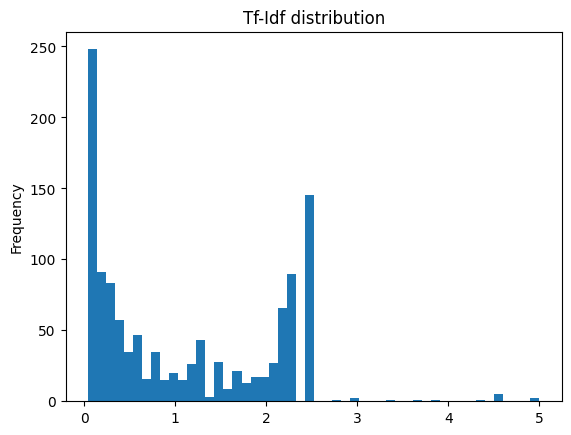

100%|█████████████████████████████████████████████████████████████████████████████████| 296/296 [01:55<00:00,  2.57it/s]


New links of clusters:
Nr of links that are equal to one of max values:  28
[(5.847899977644008, 150, 149), (6.8876207484839265, 163, 165), (5.964618506443701, 130, 133), (6.216982912406023, 31, 288), (6.8876207484839265, 165, 163), (5.847899977644008, 149, 150), (5.847899977644008, 250, 149), (5.847899977644008, 149, 250), (5.964618506443701, 133, 130), (6.216982912406023, 288, 31)]
Overlapping trips in two clusters: 32 289 Trips:  594 592
Overlapping trips in two clusters: 289 32 Trips:  592 594
[(5.847899977644008, 150, 149), (6.8876207484839265, 163, 165), (5.964618506443701, 130, 133), (3.1084914562030117, 31, 288), (6.8876207484839265, 165, 163), (5.847899977644008, 149, 150), (5.847899977644008, 250, 149), (5.847899977644008, 149, 250), (5.964618506443701, 133, 130), (3.1084914562030117, 288, 31)]
166 164
164 166
134 131
131 134
251 150
Homogeneity: 0.839
Completeness: 0.686
V-measure: 0.755
Rand index: 0.978
ARI: 0.397
MI: 3.297
NMI: 0.755
AMI: 0.536
Cluster accuracy: 0.439
Ite

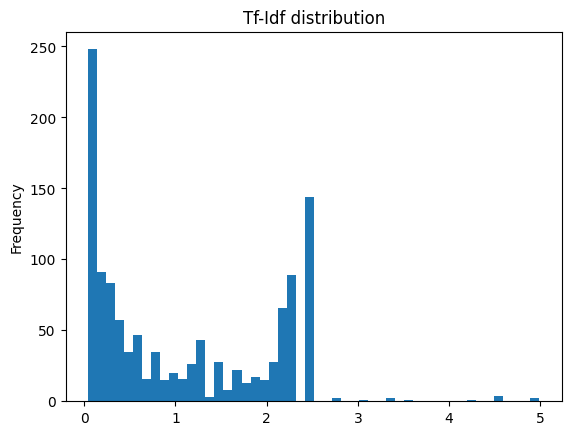

100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [01:52<00:00,  2.60it/s]


New links of clusters:
Nr of links that are equal to one of max values:  28
[(6.202268580295922, 285, 31), (5.166440361244569, 19, 281), (5.401096601005847, 174, 173), (5.166440361244569, 281, 19), (5.401096601005847, 175, 174), (5.401096601005847, 174, 175), (5.066381274034533, 166, 167), (5.401096601005847, 173, 174), (6.202268580295922, 31, 285), (5.066381274034533, 167, 166)]
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 32 289 Trips:  594 592
[(3.101134290147961, 285, 31), (5.166440361244569, 19, 281), (5.401096601005847, 174, 173), (5.166440361244569, 281, 19), (5.401096601005847, 175, 174), (5.401096601005847, 174, 175), (5.066381274034533, 166, 167), (5.401096601005847, 173, 174), (3.101134290147961, 31, 285), (5.066381274034533, 167, 166)]
179 178
178 179
178 177
177 178
285 20
Homogeneity: 0.839
Completeness: 0.687
V-measure: 0.755
Rand index: 0.978
ARI: 0.399
MI: 3.295
NMI: 0.755
AMI: 0.537
Cluster accuracy: 0.440
Iteration 2 do

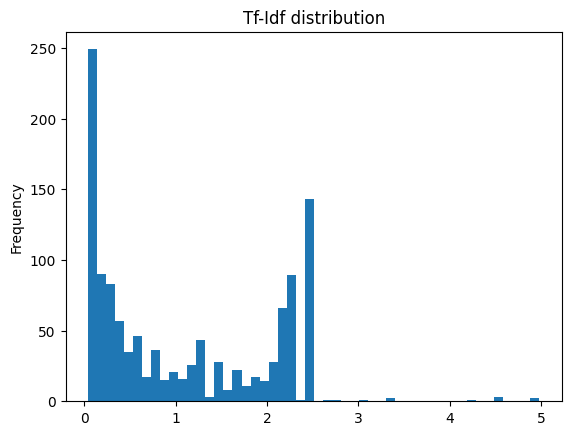

100%|█████████████████████████████████████████████████████████████████████████████████| 290/290 [01:50<00:00,  2.63it/s]


New links of clusters:
Nr of links that are equal to one of max values:  20
[(4.7371835123041555, 244, 147), (4.836269714562405, 208, 0), (4.700036764856422, 63, 123), (4.836269714562405, 0, 208), (6.187402811576463, 30, 282), (6.187402811576463, 282, 30), (5.050943744979711, 165, 166), (5.050943744979711, 166, 165), (4.7371835123041555, 147, 244), (4.700036764856422, 123, 63)]
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 32 289 Trips:  594 592
Overlapping trips in two clusters: 289 32 Trips:  592 594
[(4.7371835123041555, 244, 147), (2.4181348572812027, 208, 0), (4.700036764856422, 63, 123), (2.4181348572812027, 0, 208), (3.0937014057882317, 30, 282), (3.0937014057882317, 282, 30), (5.050943744979711, 165, 166), (5.050943744979711, 166, 165), (4.7371835123041555, 147, 244), (4.700036764856422, 123, 63)]
171 170
170 171
251 151
151 251
125 65
Homogeneity: 0.837
Completeness: 0.687
V-

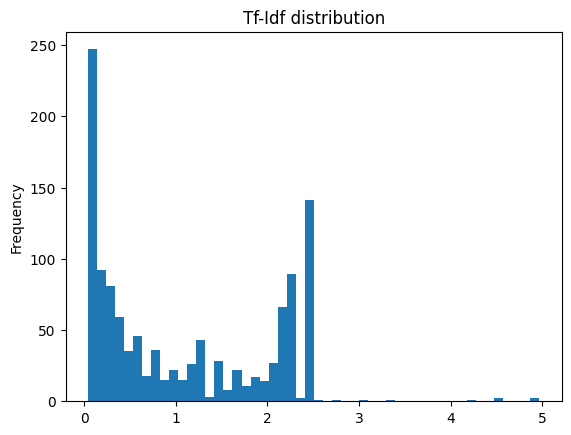

100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [01:54<00:00,  2.50it/s]


New links of clusters:
Nr of links that are equal to one of max values:  132
[(4.560869927091511, 256, 252), (4.560869927091511, 252, 256), (4.6178808011801555, 179, 62), (4.825268183734497, 0, 206), (4.6178808011801555, 62, 179), (6.172382456701833, 279, 30), (4.560869927091511, 240, 237), (4.825268183734497, 206, 0), (6.172382456701833, 30, 279), (4.560869927091511, 274, 193)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 32 289 Trips:  594 592
[(4.560869927091511, 256, 252), (4.560869927091511, 252, 256), (4.6178808011801555, 179, 62), (2.4126340918672486, 0, 206), (4.6178808011801555, 62, 179), (3.0861912283509163, 279, 30), (4.560869927091511, 240, 237), (2.4126340918672486, 206, 0), (3.0861912283509163, 30, 279), (4.560869927091511, 274, 193)]
188 64
64 188
284 202
266 262
262 266
Homogeneity: 0.837
Completeness: 0.687
V-

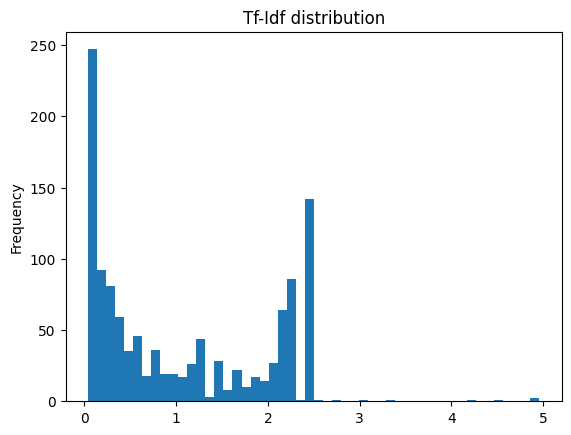

100%|█████████████████████████████████████████████████████████████████████████████████| 284/284 [02:04<00:00,  2.28it/s]


New links of clusters:
Nr of links that are equal to one of max values:  164
[(6.157204266837455, 276, 30), (4.550361949493096, 235, 238), (4.550361949493096, 219, 112), (4.814151048014435, 0, 204), (4.550361949493096, 238, 235), (4.550361949493096, 182, 189), (4.814151048014435, 204, 0), (4.550361949493096, 191, 108), (6.157204266837455, 30, 276), (4.550361949493096, 189, 182)]
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 32 289 Trips:  594 592
[(3.0786021334187277, 276, 30), (4.550361949493096, 235, 238), (4.550361949493096, 219, 112), (2.4070755240072175, 0, 204), (4.550361949493096, 238, 235), (4.550361949493096, 182, 189), (2.4070755240072175, 204, 0), (4.550361949493096, 191, 108), (3.0786021334187277, 30, 276), (4.550361949493096, 189, 182)]
249 246
246 249
230 115
201 111
199 192
Homogeneity: 0.836
Completeness: 0.688


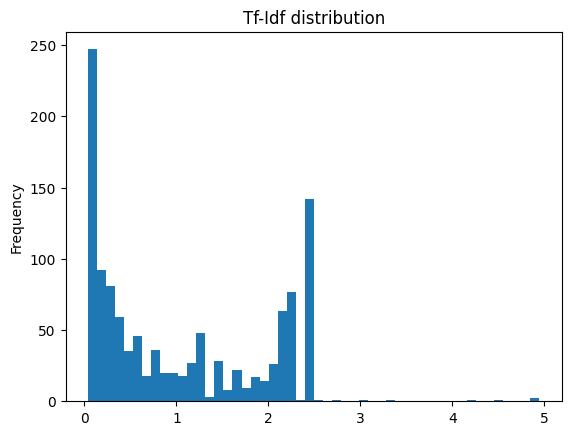

100%|█████████████████████████████████████████████████████████████████████████████████| 280/280 [02:06<00:00,  2.21it/s]


New links of clusters:
Nr of links that are equal to one of max values:  116
[(6.1367153496268525, 272, 30), (4.53617731450114, 179, 161), (4.53617731450114, 177, 132), (4.799144115341786, 0, 201), (4.799144115341786, 201, 0), (4.53617731450114, 148, 147), (4.53617731450114, 161, 179), (4.53617731450114, 154, 136), (6.1367153496268525, 30, 272), (4.53617731450114, 152, 121)]
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 32 289 Trips:  594 592
[(3.0683576748134263, 272, 30), (4.53617731450114, 179, 161), (4.53617731450114, 177, 132), (2.399572057670893, 0, 201), (2.399572057670893, 201, 0), (4.53617731450114, 148, 147), (4.53617731450114, 161, 179), (4.53617731450114, 154, 136), (3.0683576748134263, 30, 272), (4.53617731450114, 152, 121)]
191 169
189 138
169 191
161 142
159 126
Homogeneity: 0.835
Completeness: 0.688
V-measure: 0

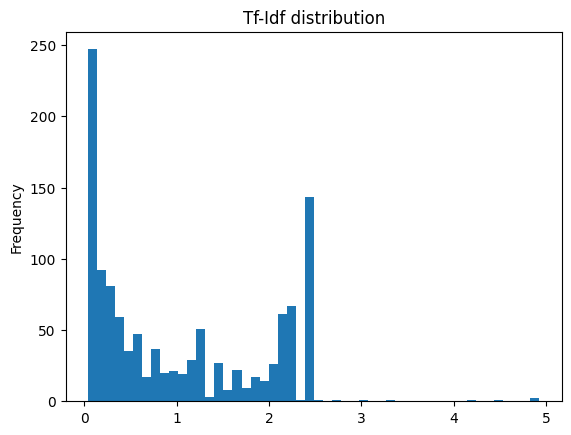

100%|█████████████████████████████████████████████████████████████████████████████████| 276/276 [02:03<00:00,  2.24it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(4.5217885770490405, 114, 111), (4.5217885770490405, 145, 144), (4.783921248182319, 0, 197), (4.5217885770490405, 115, 114), (6.115931617751597, 268, 30), (4.5217885770490405, 114, 115), (4.5217885770490405, 144, 145), (6.115931617751597, 30, 268), (4.783921248182319, 197, 0), (4.5217885770490405, 123, 96)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 32 289 Trips:  594 592
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(4.5217885770490405, 114, 111), (4.5217885770490405, 145, 144), (2.3919606240911593, 0, 197), (4.5217885770490405, 115, 114), (3.0579658088757986, 268, 30), (4.5217885770490405, 114, 115), (4.5217885770490405, 144, 145), (3.0579658088757986, 30, 268), (2.3919606240911593, 197, 0), (4.5217885770490405, 123, 96)]
155 154
154 155
129 99
120 119
119 120
Homogeneity: 0.834
Completeness

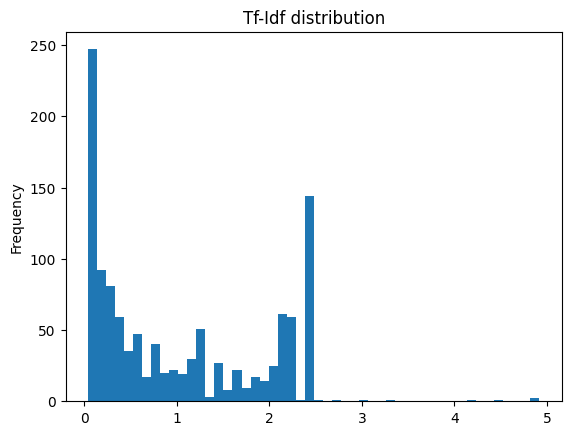

100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [01:56<00:00,  2.35it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(6.100145182538433, 265, 30), (4.455621698354552, 127, 123), (4.772358608343914, 0, 194), (4.455621698354552, 140, 123), (4.455621698354552, 212, 123), (4.51085950651685, 98, 65), (4.51085950651685, 65, 98), (6.100145182538433, 30, 265), (4.772358608343914, 194, 0), (4.455621698354552, 220, 123)]
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 32 289 Trips:  594 592
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 241 131 Trips:  32 24
[(3.0500725912692164, 265, 30), (4.455621698354552, 127, 123), (2.386179304171957, 0, 194), (4.455621698354552, 140, 123), (4.455621698354552, 212, 123), (4.51085950651685, 98, 65), (4.51085950651685, 65, 98), (3.0500725912692164, 30, 265), (2.386179304171957, 194, 0), (2.227810849177276, 220, 123)]
102 68
68 102
233 131
152 131
136 131

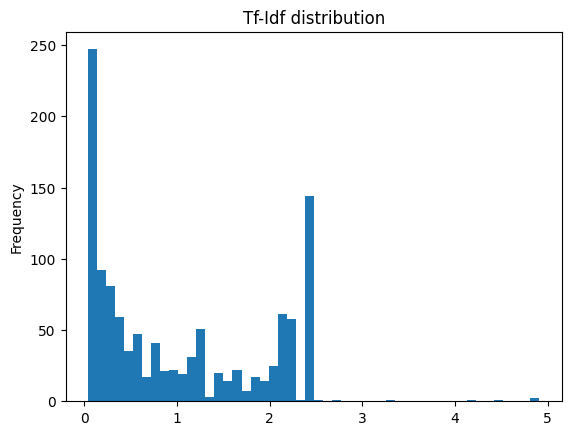

100%|█████████████████████████████████████████████████████████████████████████████████| 271/271 [01:51<00:00,  2.43it/s]


New links of clusters:
Nr of links that are equal to one of max values:  96
[(4.253311724866503, 96, 76), (6.089524219653059, 263, 30), (4.76457937465864, 192, 0), (4.76457937465864, 0, 192), (4.21582445975981, 261, 163), (4.21582445975981, 254, 118), (6.089524219653059, 30, 263), (4.366389619036946, 263, 14), (4.253311724866503, 76, 96), (4.366389619036946, 14, 263)]
Overlapping trips in two clusters: 289 32 Trips:  592 594
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 32 289 Trips:  594 592
[(4.253311724866503, 96, 76), (3.0447621098265296, 263, 30), (2.38228968732932, 192, 0), (2.38228968732932, 0, 192), (4.21582445975981, 261, 163), (4.21582445975981, 254, 118), (3.0447621098265296, 30, 263), (4.366389619036946, 263, 14), (4.253311724866503, 76, 96), (4.366389619036946, 14, 263)]
289 15
15 289
100 79
79 100
287 182
Homogeneity: 0.832
Completeness: 0.688
V-measure: 0.753
Rand index

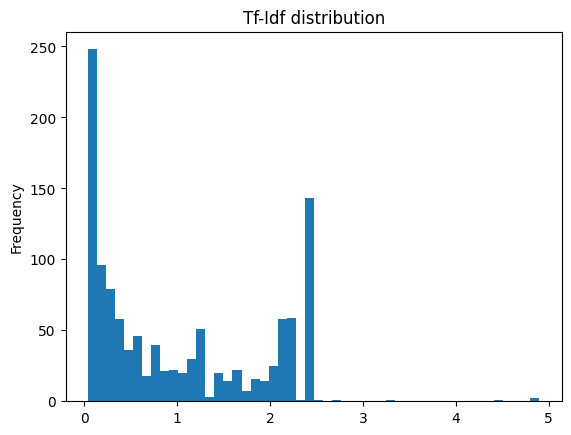

100%|█████████████████████████████████████████████████████████████████████████████████| 268/268 [01:47<00:00,  2.50it/s]


New links of clusters:
Nr of links that are equal to one of max values:  308
[(4.204692619390966, 232, 42), (4.204692619390966, 204, 41), (4.204692619390966, 252, 117), (4.752802210210442, 0, 190), (4.204692619390966, 206, 91), (4.204692619390966, 238, 237), (4.204692619390966, 214, 198), (4.204692619390966, 237, 238), (4.204692619390966, 220, 142), (4.752802210210442, 190, 0)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(4.204692619390966, 232, 42), (4.204692619390966, 204, 41), (4.204692619390966, 252, 117), (2.376401105105221, 0, 190), (4.204692619390966, 206, 91), (4.204692619390966, 238, 237), (4.204692619390966, 214, 198), (4.204692619390966, 237, 238), (4.204692619390966, 220, 142), (2.376401105105221, 190, 0)]
280 127
265 264
264 265
259 44
245 158
Homogeneity: 0.830
Completeness: 0.688
V-measure: 0.753
Rand index: 0.978
ARI: 0.402
MI: 3.263
NMI: 0.753
AMI: 0.540
Cluster accuracy: 0.444
Iteration 10 done.  2

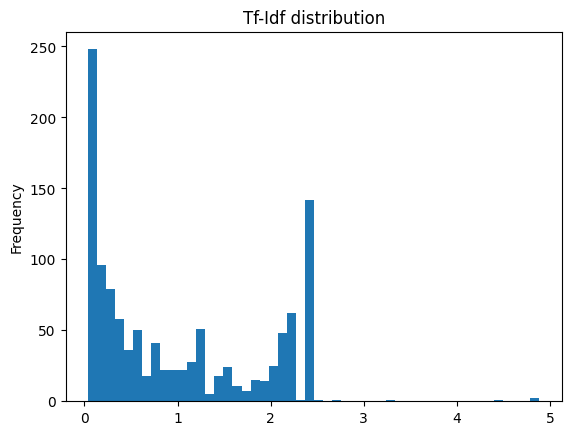

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [01:47<00:00,  2.45it/s]


New links of clusters:
Nr of links that are equal to one of max values:  212
[(4.189654742026425, 179, 180), (4.736892571839262, 187, 0), (4.736892571839262, 0, 187), (4.189654742026425, 180, 178), (4.189654742026425, 201, 41), (4.189654742026425, 195, 211), (4.189654742026425, 189, 114), (4.189654742026425, 180, 179), (4.189654742026425, 203, 90), (4.189654742026425, 211, 195)]
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
[(4.189654742026425, 179, 180), (2.368446285919631, 187, 0), (2.368446285919631, 0, 187), (4.189654742026425, 180, 178), (4.189654742026425, 201, 41), (4.189654742026425, 195, 211), (4.189654742026425, 189, 114), (4.189654742026425, 180, 179), (4.189654742026425, 203, 90), (4.189654742026425, 211, 195)]
239 223
231 94
229 43
223 239
217 124
Homogeneity: 0.830
Completeness: 0.689
V-measure: 0.753
Rand index: 0.978
ARI: 0.402
MI: 3.261
NMI: 0.753
AMI: 0.541
Cluster accuracy: 0.444
Iteration 11 done.  

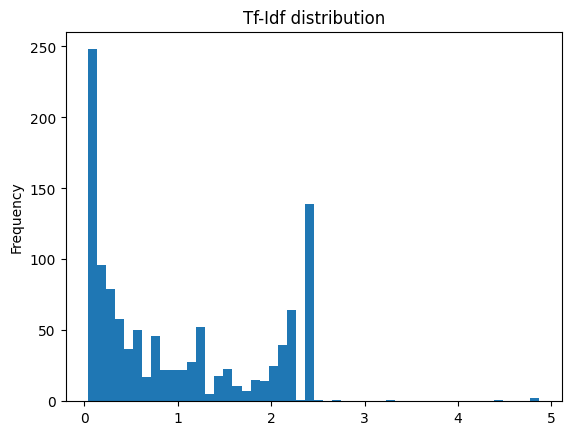

100%|█████████████████████████████████████████████████████████████████████████████████| 260/260 [01:47<00:00,  2.41it/s]


New links of clusters:
Nr of links that are equal to one of max values:  148
[(4.174387269895637, 177, 176), (4.174387269895637, 176, 175), (4.7207400288603125, 0, 184), (4.174387269895637, 177, 175), (4.174387269895637, 175, 69), (4.174387269895637, 175, 145), (4.174387269895637, 175, 176), (4.174387269895637, 175, 177), (4.174387269895637, 176, 177), (4.7207400288603125, 184, 0)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(4.174387269895637, 177, 176), (4.174387269895637, 176, 175), (2.3603700144301563, 0, 184), (4.174387269895637, 177, 175), (4.174387269895637, 175, 69), (4.174387269895637, 175, 145), (4.174387269895637, 175, 176), (4.174387269895637, 175, 177), (4.174387269895637, 176, 177), (2.3603700144301563, 184, 0)]
208 207
208 206
207 208
207 206
206 208
Homogeneity: 0.829
Completeness: 0.689
V-measure: 0.752
Rand index: 0.978
ARI: 0.403
MI: 3.259
NMI: 0.752
AMI: 0.541
Cluster accuracy: 0.444
Iteration 12

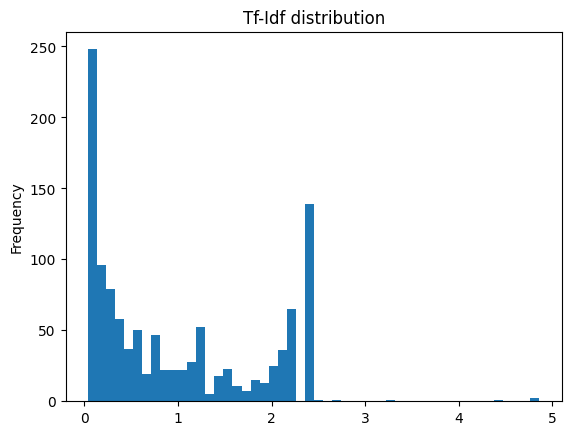

100%|█████████████████████████████████████████████████████████████████████████████████| 258/258 [01:41<00:00,  2.54it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(4.1666652238017265, 120, 136), (4.1666652238017265, 154, 155), (4.7125703279203774, 0, 182), (4.1666652238017265, 151, 150), (4.1666652238017265, 145, 69), (4.1666652238017265, 136, 120), (4.1666652238017265, 150, 151), (4.7125703279203774, 182, 0), (4.1666652238017265, 155, 154), (4.1666652238017265, 69, 145)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(4.1666652238017265, 120, 136), (4.1666652238017265, 154, 155), (2.3562851639601887, 0, 182), (4.1666652238017265, 151, 150), (4.1666652238017265, 145, 69), (4.1666652238017265, 136, 120), (4.1666652238017265, 150, 151), (2.3562851639601887, 182, 0), (4.1666652238017265, 155, 154), (4.1666652238017265, 69, 145)]
181 180
180 181
175 174
174 175
168 74
Homogeneity: 0.829
Completeness: 0.689
V-measure: 0.752
Rand index: 0.978
ARI: 0.403
MI: 3.256
NMI: 0.752
AMI: 0.541
Cluster accuracy: 0.445


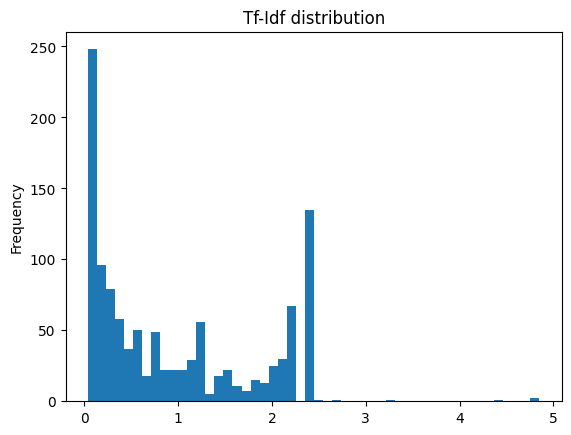

100%|█████████████████████████████████████████████████████████████████████████████████| 255/255 [01:40<00:00,  2.55it/s]


New links of clusters:
Nr of links that are equal to one of max values:  128
[(4.700196256866567, 179, 0), (3.9318256327243257, 242, 182), (4.700196256866567, 0, 179), (3.9318256327243257, 238, 229), (3.9318256327243257, 211, 210), (3.9318256327243257, 229, 238), (4.154969184038536, 135, 119), (4.154969184038536, 119, 135), (3.9318256327243257, 247, 206), (3.9318256327243257, 210, 211)]
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
[(2.3500981284332836, 179, 0), (3.9318256327243257, 242, 182), (2.3500981284332836, 0, 179), (3.9318256327243257, 238, 229), (3.9318256327243257, 211, 210), (3.9318256327243257, 229, 238), (4.154969184038536, 135, 119), (4.154969184038536, 119, 135), (3.9318256327243257, 247, 206), (3.9318256327243257, 210, 211)]
157 137
137 157
288 243
283 218
279 270
Homogeneity: 0.828
Completeness: 0.689
V-measure: 0.752
Rand index: 0.978
ARI: 0.403
MI: 3.253
NMI: 0.752
AMI: 0.542
Cluster accuracy: 0.446


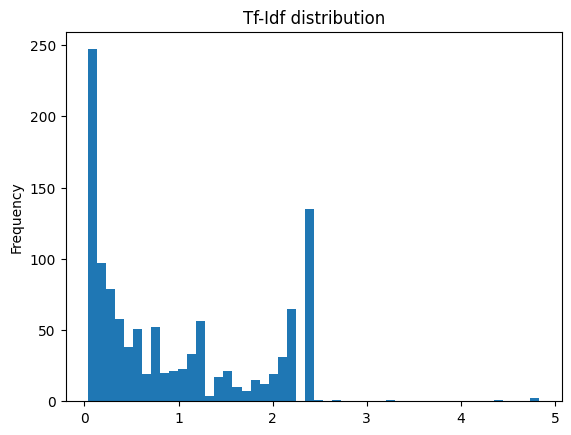

100%|█████████████████████████████████████████████████████████████████████████████████| 251/251 [01:33<00:00,  2.70it/s]


New links of clusters:
Nr of links that are equal to one of max values:  116
[(4.683469093968815, 178, 0), (3.9160150266976834, 200, 181), (4.683469093968815, 0, 178), (3.9160150266976834, 207, 208), (3.9160150266976834, 100, 95), (3.9160150266976834, 100, 98), (3.9160150266976834, 181, 45), (3.9160150266976834, 208, 207), (3.9160150266976834, 181, 200), (3.9160150266976834, 200, 45)]
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
[(2.3417345469844073, 178, 0), (3.9160150266976834, 200, 181), (2.3417345469844073, 0, 178), (3.9160150266976834, 207, 208), (3.9160150266976834, 100, 95), (3.9160150266976834, 100, 98), (3.9160150266976834, 181, 45), (3.9160150266976834, 208, 207), (3.9160150266976834, 181, 200), (3.9160150266976834, 200, 45)]
248 247
247 248
238 219
238 49
219 238
Homogeneity: 0.828
Completeness: 0.689
V-measure: 0.752
Rand index: 0.978
ARI: 0.403
MI: 3.252
NMI: 0.752
AMI: 0.543
Cluster accuracy: 0.448
Itera

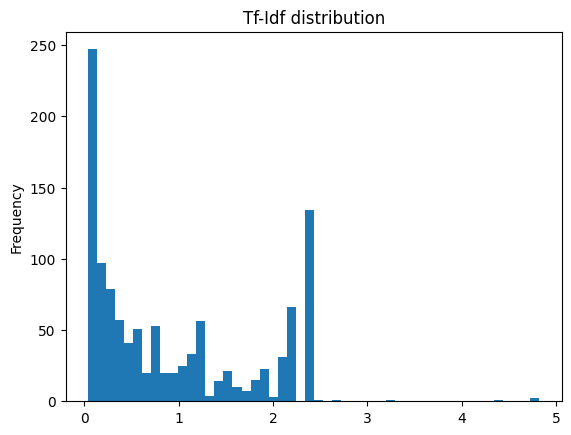

100%|█████████████████████████████████████████████████████████████████████████████████| 248/248 [01:32<00:00,  2.67it/s]


New links of clusters:
Nr of links that are equal to one of max values:  44
[(4.670747846337271, 177, 0), (3.903990833730882, 94, 99), (4.670747846337271, 0, 177), (3.8473264910773803, 246, 245), (3.903990833730882, 99, 97), (3.8473264910773803, 245, 246), (3.903990833730882, 97, 94), (3.903990833730882, 97, 99), (3.903990833730882, 99, 94), (3.903990833730882, 94, 97)]
Overlapping trips in two clusters: 215 1 Trips:  580 572
Overlapping trips in two clusters: 1 215 Trips:  572 580
[(2.3353739231686355, 177, 0), (3.903990833730882, 94, 99), (2.3353739231686355, 0, 177), (3.8473264910773803, 246, 245), (3.903990833730882, 99, 97), (3.8473264910773803, 245, 246), (3.903990833730882, 97, 94), (3.903990833730882, 97, 99), (3.903990833730882, 99, 94), (3.903990833730882, 94, 97)]
110 108
110 105
108 110
108 105
105 110
Homogeneity: 0.828
Completeness: 0.690
V-measure: 0.752
Rand index: 0.978
ARI: 0.403
MI: 3.252
NMI: 0.752
AMI: 0.544
Cluster accuracy: 0.450
Iteration 16 done.  246 clusters 

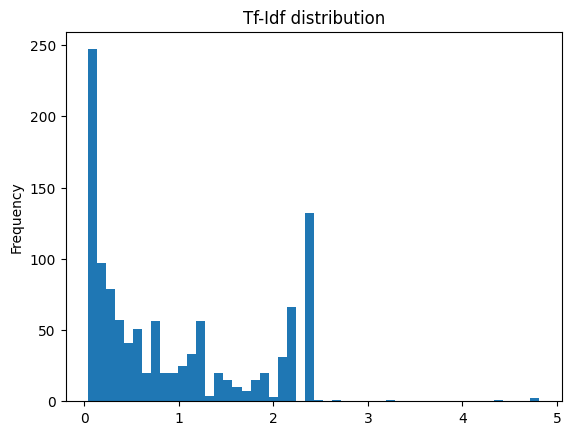

100%|█████████████████████████████████████████████████████████████████████████████████| 246/246 [01:27<00:00,  2.82it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(3.713572066704308, 228, 144), (4.662181232612905, 0, 175), (4.662181232612905, 175, 0), (3.8392292808447612, 243, 244), (3.713572066704308, 228, 227), (3.713572066704308, 153, 144), (3.713572066704308, 227, 228), (3.8392292808447612, 244, 243), (3.713572066704308, 227, 144), (3.713572066704308, 153, 152)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(3.713572066704308, 228, 144), (2.3310906163064526, 0, 175), (2.3310906163064526, 175, 0), (3.8392292808447612, 243, 244), (3.713572066704308, 228, 227), (3.713572066704308, 153, 144), (3.713572066704308, 227, 228), (3.8392292808447612, 244, 243), (3.713572066704308, 227, 144), (3.713572066704308, 153, 152)]
295 294
294 295
278 277
278 173
277 278
Homogeneity: 0.827
Completeness: 0.690
V-measure: 0.752
Rand index: 0.978
ARI: 0.404
MI: 3.250
NMI: 0.752
AMI: 0.545
Cluster accuracy: 0.450
Iteration

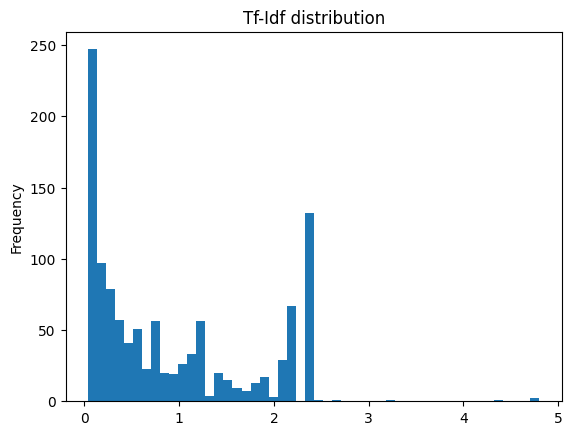

100%|█████████████████████████████████████████████████████████████████████████████████| 243/243 [01:25<00:00,  2.83it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(3.660140107348765, 191, 95), (4.649199830305624, 0, 174), (3.660140107348765, 191, 115), (3.660140107348765, 191, 112), (4.649199830305624, 174, 0), (3.660140107348765, 191, 113), (3.660140107348765, 191, 128), (3.7013019741124933, 152, 151), (3.660140107348765, 128, 191), (3.7013019741124933, 151, 152)]
Overlapping trips in two clusters: 1 215 Trips:  572 580
Overlapping trips in two clusters: 215 1 Trips:  580 572
[(3.660140107348765, 191, 95), (2.324599915152812, 0, 174), (3.660140107348765, 191, 115), (3.660140107348765, 191, 112), (2.324599915152812, 174, 0), (3.660140107348765, 191, 113), (3.660140107348765, 191, 128), (3.7013019741124933, 152, 151), (3.660140107348765, 128, 191), (3.7013019741124933, 151, 152)]
187 186
186 187
233 152
233 136
233 133
Homogeneity: 0.825
Completeness: 0.690
V-measure: 0.751
Rand index: 0.978
ARI: 0.403
MI: 3.241
NMI: 0.751
AMI: 0.543
Cluster accuracy: 0.450
Iteration 18 

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [29]:
iteration = 1

# Define stopping criteria (either k is reached or min_sim is triggered)
K_target = 74

points = get_points(gdf, tessellation)
loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
Min_sim = loc_frequencies.tf_idf.quantile(0.7)**2
print(f"Min Sim threshold: {Min_sim}")

while True:
    print('\nNext Iteration: ', iteration)
    # Get new points gdf matched with tessellation that contains updated clustering column
    points = get_points(gdf, tessellation)
    
    # Compute location entropy for latest clustering (inverse normalized entropy)
#     points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))
#     points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))
#     points.location_entropy.plot.hist(bins=30, title="Inverse location_entropy distribution")
#     plt.show()
    
    # Update location frequencies and loc frequency-inverse cluster frequency
    loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
    loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
    loc_frequencies.tf_idf.plot.hist(bins=50, title="Tf-Idf distribution")
    plt.show()
    
    # Recalculate similarities between latest clusters
    M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))
    for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
        for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
            if i == j:
                continue
            M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)
    np.fill_diagonal(M, 0)
    
    # Select n best links and assign new clustering IDs
    print('New links of clusters:')
    max_n =  get_max_n(M)
    # Adjust scores based on overlapping trips in the two candidate clusters
    print(max_n)
    max_n = [(t[0] * 1/(find_nr_overlaps(loc_frequencies.clustering_HL.unique()[t[1]], loc_frequencies.clustering_HL.unique()[t[2]], gdf) + 1), t[1], t[2]) for t in max_n]
    print(max_n)
    
    # Take the 5 best fitting clusters
    for i, tup in enumerate(sorted(max_n, reverse=True)[:5]):
        cl_1 = loc_frequencies.clustering_HL.unique()[tup[1]]
        cl_2 = loc_frequencies.clustering_HL.unique()[tup[2]]
        print(cl_1, cl_2)
        # Assign new clustering ids (merge clustering ids)
        gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)
    
    # Evaluate result of iteration
    attack.evaluate(gdf.clustering_HL.tolist(), gdf)
    store_results_recursive_search(gdf.clustering_HL.tolist(), gdf)
    
    print('Iteration', iteration, 'done. ', gdf.clustering_HL.nunique(), 'clusters left.')
    
    # Check break conditions
    if gdf.clustering_HL.nunique() <= K_target:
        print("K clusters reached! Done!")
        save_clustering_result(gdf, data_name="freemove_private_500tessellation")
        break
    if sorted(max_n, reverse=True)[0][0] < Min_sim:
        print("No good matches to make left! Done!")
        save_clustering_result(gdf, data_name="freemove_private_500tessellation")
        break
                
    iteration += 1

In [ ]:
gdf.drop(['START_POINT', 'END_POINT'], axis=1).to_file("data/freemove/freemove_clustering_tfidf.geojson", driver="GeoJSON")